# Crop, segment and visualize an image using CVPy

This notebook demonstrates how to use CVPy to assist with visualization within an end-to-end biomedical image analysis pipeline.

Biomedical tools within SAS Viya can assist with a real-world biomedical image analytics problem. In this example, an image is loaded from the LUNGx SPIE-AAPM-NCI Lung Nodule Classification Challenge data set and cropped to highlight a benign nodule on the lung. The image is then segmented to create a binary image. This segmentation is used as a mask to recover the original pixel values of the image. Next, the image's histogram is calculated using quantifyBioMedImages.

Data source: https://wiki.cancerimagingarchive.net/display/Public/LUNGx+SPIE-AAPM-NCI+Lung+Nodule+Classification+Challenge

### Load python packages

In [1]:
from swat import *
from mayavi import mlab

### Import CVPy

In [2]:
from cvpy.visualization import *

### Connect to server

In [3]:
# Connect to the SAS CAS Server
s = CAS("your-host-name.unx.com", 5570)
s.loadactionset("image")
s.loadactionset("biomedimage")
s.loadactionset("fedsql")

s.addcaslib(
    name="dlib",
    activeOnAdd=True,
    path="path/to/caslib",
    dataSource="PATH",
    subdirectories=True,
)

NOTE: Added action set 'image'.
NOTE: Added action set 'biomedimage'.
NOTE: Added action set 'fedsql'.
NOTE: 'dlib' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'dlib'.


,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
0,dlib,PATH,,/net/narndnas02.unx.sas.com/vol/vol2/fvcc/BMID...,,1.0,1.0,1.0,0.0,0.0,0.0


### Load slides

In [4]:
slides_dir = "CVPY_demo/CVPy_crop_demo"  # Slides
caslib_name = "casuser"

def load_slides(cas_session, slides_table):
    """Load the slides."""
    casout = s.CASTable(slides_table, replace=True)
    s.image.loadimages(path=slides_dir, caslib="casuser", casout=casout, decode=True)
    fetched_slides = casout[["_resolution_", "_image_", "_path_"]].to_frame()
    slide_binaries = fetched_slides["_image_"]
    slide_resolutions = fetched_slides["_resolution_"]
    slide_paths = fetched_slides["_path_"]
    res = np.frombuffer(slide_resolutions[0], np.int64)
    slide_width = res[0]
    slide_height = res[1]
    return slide_binaries, slide_paths, slide_width, slide_height


slide_binaries, slide_paths, slide_width, slide_height = load_slides(s, "slides")

NOTE: Loaded 5 images from /u/coambr/CVPY_demo/CVPy_crop_demo into Cloud Analytic Services table slides.


NOTE: The table SLIDES contains decoded images.


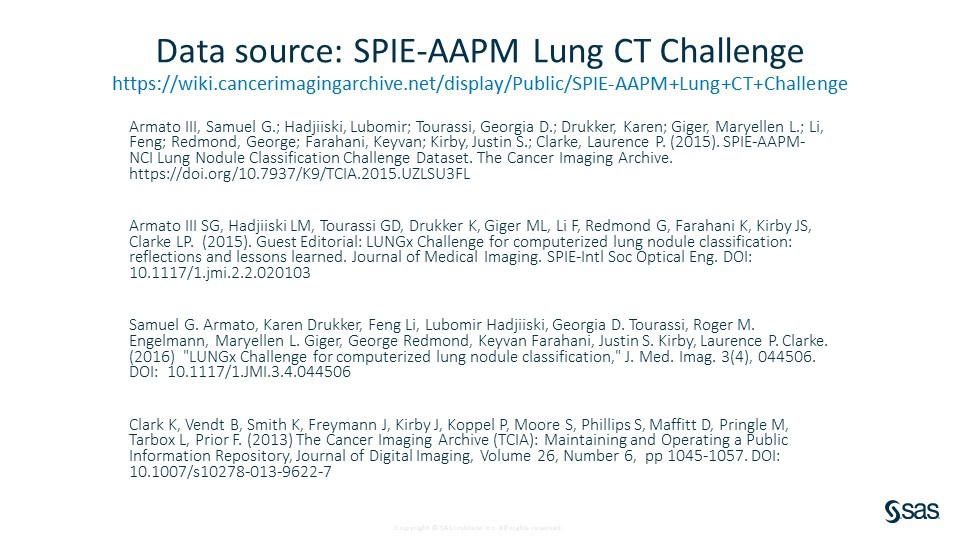

In [5]:
s.image.fetchImages(imageTable="slides").Images.Image[0]

### Load the image

In [6]:
torso = s.CASTable(name="torso", replace=True)

s.image.loadimages(
    path="DemoData/LungNoduleClassification/TrainDataOriginal/CT-Training/CT-Training-BE007",
    caslib="dlib",
    labellevels=1,
    recurse=True,
    series=dict(dicom=True),
    decode=True,
    addcolumns=dict(
        general=[
            "width",
            "height",
            "depth",
            "channeltype",
            "position",
            "orientation",
            "spacing",
        ],
        dicomAttributes=dict(keywords=["PatientAge", "PatientSex", "AcquisitionDate"]),
    ),
    casOut=torso,
)

NOTE: Loaded 1 image from /net/narndnas02.unx.sas.com/vol/vol2/fvcc/BMIData/DemoData/LungNoduleClassification/TrainDataOriginal/CT-Training/CT-Training-BE007 into Cloud Analytic Services table torso.


,casLib,Name,Rows,Columns,casTable
0,dlib,torso,1,19,"CASTable('torso', caslib='dlib')"


### Display the original image
This CVPy function will display three slices of the image on the x, y, and z axis in Mayavi. These slices are adjustable through the Mayavi interface so that all 3D image information is observable.

In [7]:
display_3D_image_slices(s, "torso")

NOTE: The table SLIDES contains decoded images.


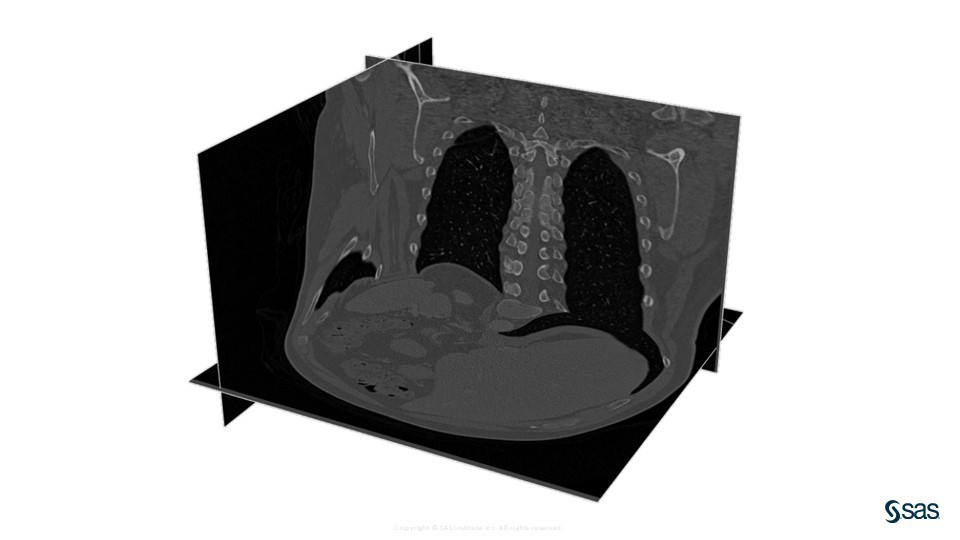

In [8]:
s.image.fetchImages(imageTable="slides").Images.Image[1]

### Crop the image to the lung nodule

In [9]:
nodule = s.CASTable(name="nodule", replace=True)

s.biomedimage.processbiomedimages(
    images=dict(table=torso),
    steps=[
        dict(
            stepparameters=dict(
                steptype="crop",
                cropparameters=dict(
                    croptype="basic", imagesize=[29, 32, 11], pixelIndex=[371, 190, 141]
                ),
            )
        ),
        dict(
            stepparameters=dict(
                steptype="rescale", rescaleparameters=dict(rescaletype="channeltype_8u")
            )
        ),
    ],
    decode=True,
    copyVars=["_label_", "_path_", "_type_", "_id_"],
    addColumns={"WIDTH", "HEIGHT", "DEPTH", "CHANNELTYPE", "SPACING", "ORIENTATION"},
    casout=nodule,
)

NOTE: Processed 1 image from Cloud Analytic Services table TORSO.


,casLib,Name,Rows,Columns,casTable
0,dlib,nodule,1,15,"CASTable('nodule', caslib='dlib')"


### Display the lung nodule
Using the same CVPy function that we used previously, we can observe the result of the cropping. In this function call, we also include three integers to specify which slice to display in the x, y, and z direction.

In [10]:
display_3D_image_slices(s, "nodule", 2, 2, 2)

NOTE: The table SLIDES contains decoded images.


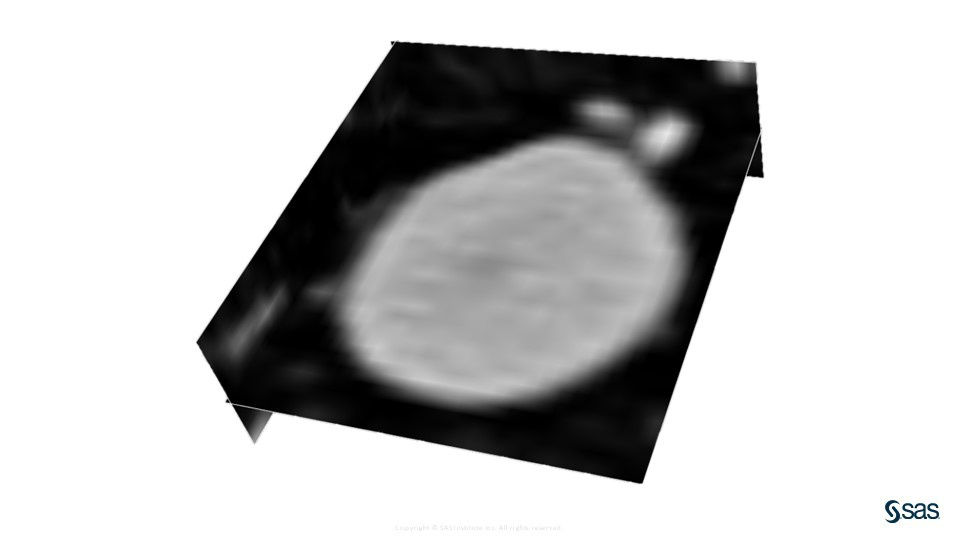

In [11]:
s.image.fetchImages(imageTable="slides").Images.Image[2]

### Segment the image using K-means segmentation

In [12]:
mask = s.CASTable(name="mask", replace=True)

s.biomedimage.segmentbiomedimages(
    images=dict(table="nodule"),
    method=dict(name="kmeans", kmeansparameters=dict(kmeanstype="basic", regions=2)),
    decode=True,
    copyvars=["_id_"],
    addColumns={"WIDTH", "HEIGHT", "DEPTH", "CHANNELTYPE", "SPACING", "ORIENTATION", "POSITION"},
    casout=mask,
)

NOTE: Segmented 1 image from Cloud Analytic Services table NODULE.


,casLib,Name,Rows,Columns,casTable
0,dlib,mask,1,13,"CASTable('mask', caslib='dlib')"


### Display the segmentation image

In [13]:
display_3D_image_slices(s, "mask")

NOTE: The table SLIDES contains decoded images.


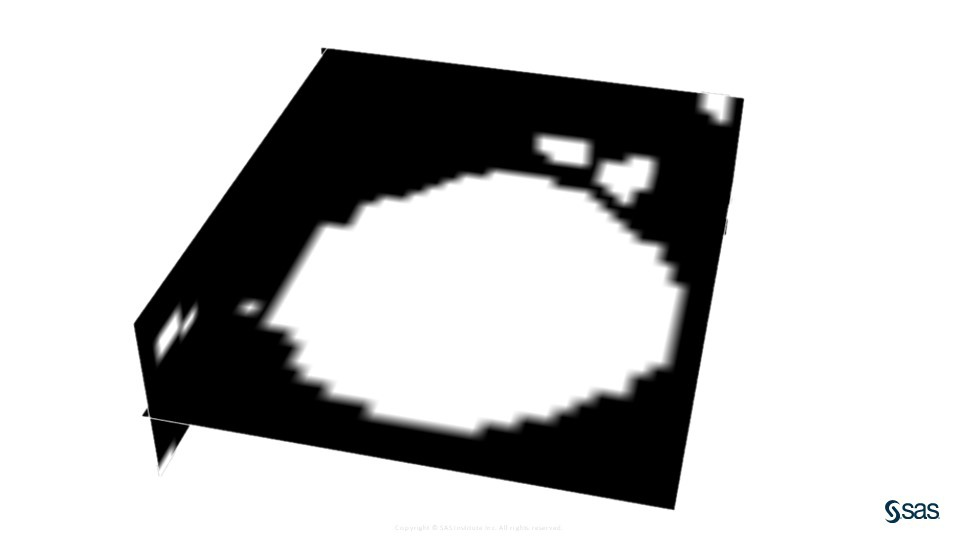

In [14]:
s.image.fetchImages(imageTable="slides").Images.Image[3]

In [15]:
s.table.altertable(
    table="mask",
    columns=[
        dict(name="_image_", rename="seg"),
        dict(name="_dimension_", rename="dim"),
        dict(name="_resolution_", rename="res"),
        dict(name="_imageformat_", rename="form"),
        dict(name="_orientation_", rename="ori"),
        dict(name="_position_", rename="pos"),
        dict(name="_spacing_", rename="spa"),
    ],
)

images_to_mask = s.CASTable("images_to_mask", replace=True)
s.fedsql.execdirect(
    "create table images_to_mask {options replace=true} as "
    "select a.*, b._image_, b._orientation_, b._spacing_, b._dimension_, b._imageFormat_, b._resolution_ "
    "from mask as a inner join nodule as b "
    "on a._id_=b._id_"
)

NOTE: Table IMAGES_TO_MASK was created in caslib dlib with 1 rows returned.


+ Elapsed: 0.456s, user: 1.18s, sys: 0.221s, mem: 143mb

### Mask the original image using the segmentation image

In [16]:
masked_img = s.CASTable("masked_img", replace=True)

s.biomedimage.processbiomedimages(
    images=dict(table=images_to_mask),
    steps=[
        dict(
            stepparameters=dict(
                steptype="binary_operation",
                binaryoperation=dict(
                    binaryoperationtype="mask_specific",
                    image="seg",
                    dimension="dim",
                    resolution="res",
                    imageformat="form",
                    outputBackground=0,
                ),
            )
        )
    ],
    decode=True,
    addColumns={"WIDTH", "HEIGHT", "DEPTH", "CHANNELTYPE", "SPACING", "ORIENTATION", "POSITION"},
    casout=masked_img,
    copyvars=["_id_"],
)

NOTE: Processed 1 image from Cloud Analytic Services table IMAGES_TO_MASK.


,casLib,Name,Rows,Columns,casTable
0,dlib,masked_img,1,13,"CASTable('masked_img', caslib='dlib')"


### Display the masked image

In [17]:
display_3D_image_slices(s, "masked_img")

NOTE: The table SLIDES contains decoded images.


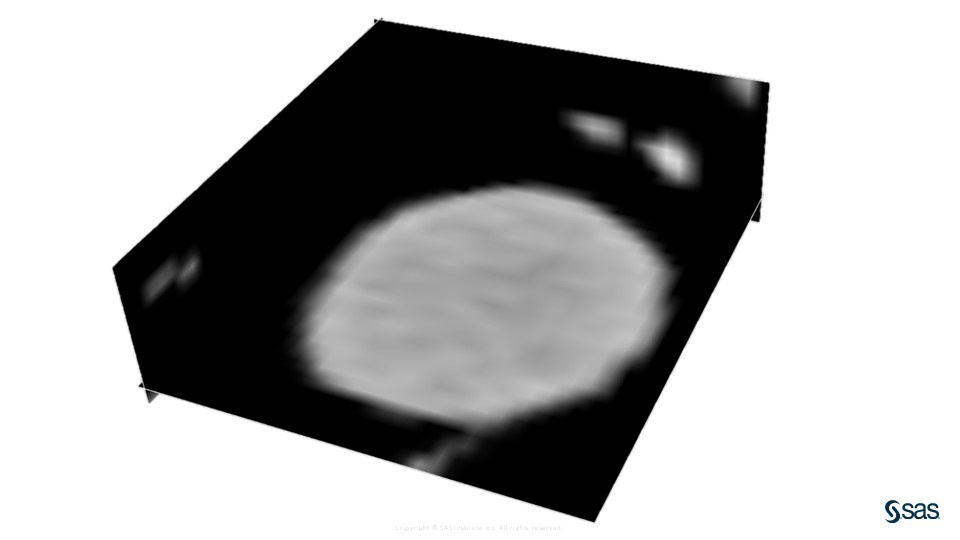

In [18]:
s.image.fetchImages(imageTable="slides").Images.Image[4]

### Quantify image metrics

In [19]:
histogram = s.CASTable(name="histogram", replace=True)

s.biomedimage.quantifyBioMedImages(
    images=dict(table="masked_img"),
    region="image",
    quantities=[
        dict(quantityparameters=dict(quantitytype="histogram", min=1, max=256, bins=50))
    ],
    casout=histogram,
)

histogram_output = histogram.to_frame().drop(columns=["_imageId_"])

NOTE: Processed 1 image from Cloud Analytic Services table MASKED_IMG.


### Plot the histogram

Text(0.5, 1.0, 'Histogram')

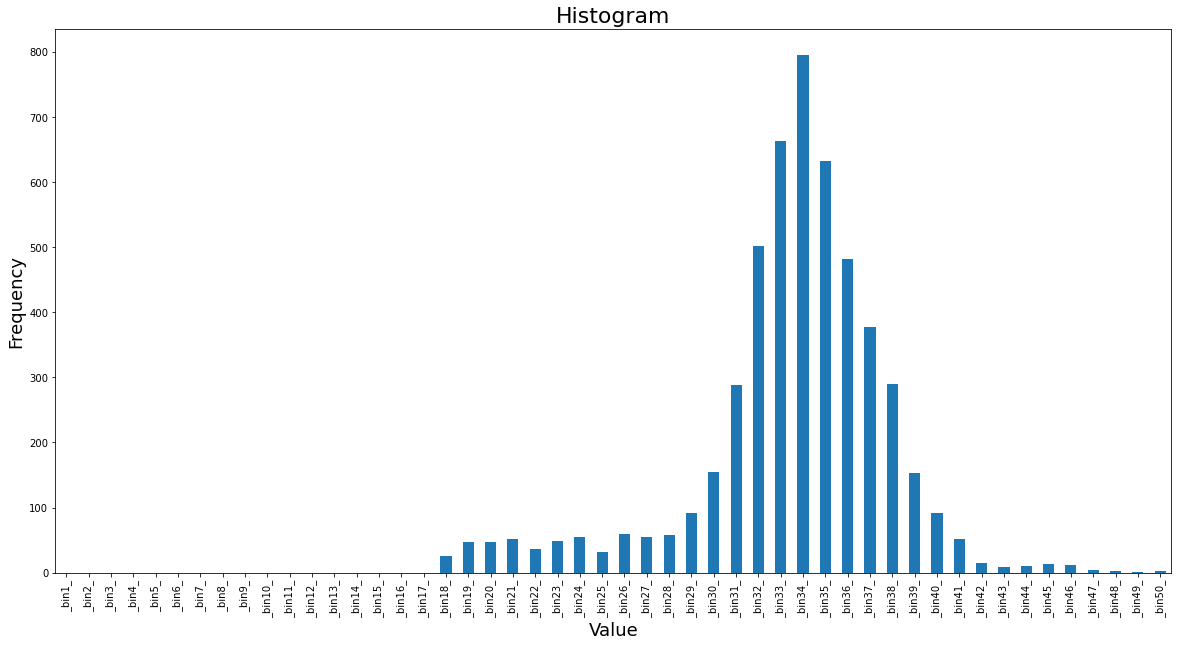

In [20]:
fig = plt.figure(figsize=(20, 10))
histogram_output.iloc[0].plot.bar()
plt.xlabel("Value", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.title("Histogram", fontsize=22)